<a href="https://colab.research.google.com/github/KravitzLab/PsygeneAnalyses/blob/PCA_analysis/Kravitz_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PCA plotting for PsyGene Mice Behavior

# Import Libraries

In [6]:
####### Import Needed Libraries #######
# Libraries for Machine Learnings/Modeling
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.model_selection import train_test_split
# Libraries for importing
import zipfile
from google.colab import files # creates the ability for display uploads
import tempfile
import io
import os
# Data Frame libraries
import pandas as pd
import numpy as np
# for merging
from functools import reduce

from decorator import DEF

import ipywidgets as widgets

# Define functions used through out the script

In [17]:
####### DEFINE ALL FUNCTIONS #######

### Session type Extraction ###
# This code will extract the "session_type" column from each file
def extract_session_type(df, file_name, fallback="Unknown"):
    # Follow Naming conventions so far
    session_types = ["weight", "bandit100", "fr1", "beam", "bandit80",
                     "_pr_", # we have to define pr surrounded by underscores to prevent random pr's
                     "individual_behavoir", "social_interaction", "nesting"]
    """Read 'Session_Type ' or variants; return first non-empty value."""
    file_name = file_name.lower()
    print(f"Extracting session type for file: {file_name}")
    try:
        #df = pd.read_csv(csv_path, sep=None, engine='python', dtype=str)
        df = df
        df.columns = [c.strip() for c in df.columns]
        lower = {c.casefold(): c for c in df.columns}
        # Loop through common session like column names
        for cand in ["session_type", "session type", "sessiontype", "session"]:
            if cand in lower:
                col = lower[cand]
                vals = df[col].dropna().astype(str).str.strip()
                vals = vals[vals.ne("")]
                if not vals.empty:
                    return vals.iloc[0].lower()
            else:
              # use the file name to determine what session type it is
              matches = [c for c in session_types if c.lower() in file_name.lower()]
              return(matches[0])

    except Exception as e:
        print(f"Error reading {csv_path}: {e}")
    return fallback

### Retrieve dataframe profiles ###
# expects a dataframe as an argument
def df_prof(df):
  # Get Dimensions
  print(f"Number of rows: {df.shape[0]}")
  print(f"Number of columns: {df.shape[1]}")

  # Data types
  df_prof = df.dtypes.rename("DataType")

  # Null percentages
  df_null = (df.isna().sum() / len(df) * 100).rename("Percent_Null")

  # unique counts
  df_uniq = df.nunique().rename("Number_Unique")

  # Merge into one DataFrame
  merged_df = pd.concat([df_prof, df_null, df_uniq], axis=1).reset_index()
  merged_df.columns = ["Column", "DataType", "Percent_Null", "Number_Unique"]
  print(merged_df)



### Clean Session Dataframes ###
# Very fragile and expects the user to do manual investigation
# could add detection for columns with null values
# define this as a function for better readbility and to easily adjust
#   drop lists
def clean_session_types(session_dfs, all_drops, percent_drop = 5):
  # Interate through large table and remove
  for s, d in session_dfs.items():
    print(f"Cleaning Session Type: {s}")

    # remove "$" from column names
    session_dfs[s].columns = session_dfs[s].columns.str.replace('$', '')

    ### Conduct general data cleaning ###
    session_dfs[s] = session_dfs[s].drop(columns = all_drops, errors='ignore')

    # Calculate the percentage of null values for each column
    null_percentages = session_dfs[s].isnull().sum() * 100 / len(session_dfs[s])

    # Identify columns where the null percentage is greater than 5%
    columns_to_drop = null_percentages[null_percentages > percent_drop].index

    # Drop the identified columns from the DataFrame
    session_dfs[s] = session_dfs[s].drop(columns=columns_to_drop)
    """
    ### Clean bandit80 specific data ###
    if s.lower() in ["bandit80", "bandit100"]:
      session_dfs[s] = session_dfs[s].drop(columns = bandit_drops, errors='ignore')
      # Ensure date times are correct data type
      session_dfs[s]['FED_StartDate'] = pd.to_datetime(session_dfs[s]['FED_StartDate'])

    ### Clean weight specific data ###
    if s.lower() in ["weight"]:

      session_dfs[s] = session_dfs[s].drop(columns = weight_drops, errors='ignore')
      # Ensure date times are correct data type
      session_dfs[s]['DOB'] = pd.to_datetime(session_dfs[s]['DOB'])

    # remove session type after all the cleaning
    session_dfs[s] = session_dfs[s].drop(columns = "session_type", errors='ignore')
  """
  ### Return the session_dfs ###
  return(session_dfs)



### Define easy function for finding mode ###
def mode_or_nan(x):
    # handle ties or empty groups safely
    return x.mode().iloc[0] if not x.mode().empty else None


### Aggregate Session Dataframes ###
# expects dictionary containing dataframes
# Requires "Mouse_ID" Column
# Will iterate through dataframes within the session dictionary passed
#     and aggregate by Mouse_ID and ensure only 1 mouse is represented.
# define this as a function for better readbility and to easily adjust
#   drop lists
def aggregate_session_types(session_dfs):
    # Iterate across the session dictionary
    for s, d in session_dfs.items():
        print(f"Aggregating Session Type: {s}")

        # Check to see if primary key is same length as number of rows in dataframe
        if len(d) == d["Mouse_ID"].nunique():
            print("Number of Mice equal to Length of dataframe: No Aggregation Needed")
            continue

        # Define numeric and categorical columns
        numeric_cols = d.select_dtypes(include=['int64', 'float64']).columns
        object_cols = d.select_dtypes(include=['object', 'category', 'datetime64']).columns

        # perform aggregation
        agg_dict = {
            **{col: 'mean' for col in numeric_cols},
            **{col: mode_or_nan for col in object_cols}
        }

        session_dfs[s] = (d.groupby('Mouse_ID', dropna=False, as_index=False)
                          .agg(agg_dict))
    return session_dfs

# Import Wanted Data Files
Code based on Chantelle Murelle and Sebastian Alves

The following code will iteritvly read all csv's within the zipped file and seperate them into a dictionary based on the various recordings. this will be used for processing the data in a session type manner.

This could include L3 for all various recordings:
1.   Weight
2.   Bandit100_0
3.   FR1
4.   BEAM
5.   Bandit80_20
6.   PR
7.   Individual Behavoir
8.   Social Interaction
9.   Nesting



In [ ]:
####### Import Wanted Data Files ########
# Code based on Chantelle Murelle and Sebastian Alves

### reset cache ###
# Reset caches to avoid duplicates if you re-run this cell
session_dict, loaded_files, session_types = [], [], []

### Define the upload UI element ###
uploaded = files.upload()

### Create Data dictonary and containers ###
session_dict = {} # for storing by session type
loaded_files = [] # for files

### Loop through the uploaded files ###
# This expects a zippped file exclusivly
for name, data in uploaded.items():
  with zipfile.ZipFile(io.BytesIO(data)) as zf: # use zipfile to "unzip"
    for zi in zf.infolist(): # iterate through the zipped files


      # skip non handled file types
      # Skip non-csv/xlsx files
      if not (zi.filename.endswith(".csv") or zi.filename.endswith(".xlsx")):
        print(f"Skipping: {zi.filename}")
        continue
      print(f"\nProcessing: {zi.filename}")

      # define filetype
      file_type = "csv" if zi.filename.endswith(".csv") else "xlsx"

      # read the file in
      file_data = zf.read(zi)

      # write temporary file into memory
      suffix = ".csv" if file_type == "csv" else ".xlsx"
      with tempfile.NamedTemporaryFile(mode="w+b", suffix=suffix, delete=False) as tmp:
        tmp.write(file_data)
        tmp_path = tmp.name

      # Define try catch statment and read into memory
      try:
        if file_type == "csv":
          df = pd.read_csv(tmp_path)
        else:
          df = pd.read_excel(tmp_path)
        #df["source_file"] = zi.filename
        session_type = extract_session_type(df, zi.filename)
        # rewrite session
        df["session_type"] = session_type
        print(session_type)

        # Add to the data dictionary based on session type
        if session_type not in session_dict:
          session_dict[session_type] = []
        session_dict[session_type].append(df)
      except Exception as e: # throw error on failure to load
        print(f"Error loading {zi.filename}: {e}")
      finally: # remove the temporary path
        os.remove(tmp_path)



### Combine dataframes for each session ###
# Convert each list of dfs into one merged dataframe per session type
session_dfs = {k: pd.concat(v, ignore_index=True) for k, v in session_dict.items()}

#session_dfs.pop('weight', None)
#session_dfs.pop('bandit100', None)
session_dfs.pop('beam', None)
session_dfs.pop('si', None)

### Return overarcing view of all sessiont types ###
for s, d in session_dfs.items():
    print(f"\nSession '{s}' → {d.shape[0]} rows, {d.shape[1]} cols")
    df_prof(session_dfs[s])

# Begin to clean data.
Define what columns for what seesion types will be dropped. This should be based on nullness and should seek to keep as large an N as possible.

Additionally, columns that are believe to add little to no context could be dropped.

In [22]:
####### BEGIN DATA CLEANING AND SCRUBBING #######


# drop known problem columns
all_drops = ["filename", "filename_md", "Session_type", "match_status",
               "Primary", "Autoexcluder", "Gene_ID"]



dfs_clean = aggregate_session_types(session_dfs)


dfs_clean = clean_session_types(session_dfs=dfs_clean,
                                all_drops=all_drops)


### Return overarcing view of all sessiont types ###
for s, d in dfs_clean.items():
    print(f"\nSession '{s}' → {d.shape[0]} rows, {d.shape[1]} cols")
    df_prof(dfs_clean[s])




Aggregating Session Type: bandit80
Aggregating Session Type: fr1
Number of Mice equal to Length of dataframe: No Aggregation Needed
Aggregating Session Type: bandit100
Number of Mice equal to Length of dataframe: No Aggregation Needed
Aggregating Session Type: pr1
Number of Mice equal to Length of dataframe: No Aggregation Needed
Aggregating Session Type: weight
Number of Mice equal to Length of dataframe: No Aggregation Needed
Cleaning Session Type: bandit80
Cleaning Session Type: fr1
Cleaning Session Type: bandit100
Cleaning Session Type: pr1
Cleaning Session Type: weight

Session 'bandit80' → 218 rows, 23 cols
Number of rows: 218
Number of columns: 23
                         Column DataType  Percent_Null  Number_Unique
0                          BEAM  float64      0.000000             69
1             Win-stay_Bandit80  float64      0.000000            216
2           Lose-shift_Bandit80  float64      0.000000            194
3         PeakAccuracy_Bandit80  float64      0.458716   

# Merge and Prepare Columns

##Begin the merge of the disperate types of metric data.

Continues cleaning and data formatting including:

*   Remove any rows that have any null values present.
*   Calculate # of Days columns (if date times are present).


In [23]:
####### Merge the list of dataframes #######

# Define the features that will be merged on
merge_keys = ["Mouse_ID", "Gene", "Sex", "Genotype"]

#print(merge_keys)

### Add prefixs for columns ###
#Merge the dataframes and add a prefix to track where it came from
# add prefixs to the dataframes based  on session type to track them
prefixed_dfs = [
    df.rename(columns=lambda c: f"{s}_{c}" if c not in merge_keys else c)
    for s, df in dfs_clean.items()
]

### Merge the dataframes ###
# Merge based on multiple grouping columns
merged = reduce(
    lambda left, right: pd.merge(left, right, on=merge_keys, how="outer"),
    prefixed_dfs
)


### Remove any rows that contain null values ###
# Replace textual 'nan' with real NaN and assign
replaced = merged.replace('nan', np.nan)
# Keep only rows that have NO nulls in any column
df_all = replaced[~replaced.isnull().any(axis=1)].reset_index(drop=True)


### Deal with the dates ###
# by representing how old each mouse is (days) for various tasks
dob_col = df_all.columns[df_all.columns.str.contains("DOB")]
if not dob_col.empty:
  # Extract column
  dob_col = dob_col[0]
  print(f"Found DOB Column: {dob_col} \nCalculating days old for tasks")
  fed_starts = df_all.columns[df_all.columns.str.contains("FED_StartDate")]

  # Convert DOB column once to datetime
  dob_dt = pd.to_datetime(df_all[dob_col], errors='coerce')

  # Loop through each FED_StartDate column and calculate days difference
  for fed_col in fed_starts:
    new_col_name = f"days_old_for_{fed_col}"
    df_all[new_col_name] = (
        pd.to_datetime(df_all[fed_col], errors='coerce') - dob_dt
        ).dt.days
    print(f"→ Created column: {new_col_name}")


### Remove any datetime columns ###
datetime_cols = df_all.select_dtypes(include=['datetime64']).columns
df_all.drop(columns = datetime_cols, inplace=True)


### Check the data ###
print(df_all.columns.values)
df_prof(df_all)
#df_all.head()




# ---------- Save CSV ----------
#csv_name = f"PRmetrics_{datetime.now():%Y%m%d_%H%M%S}.csv"
csv_name = f"all_merged_dataframes.csv"

down_df = df_all.to_csv(csv_name, index=False)
#display(HTML(f"<b>✓ Saved PR metrics CSV to:</b> <code>{csv_name}</code>"))

try:
    from google.colab import files as gfiles
except Exception:
    gfiles = None

# Optional download button (works in Colab)
btn = widgets.Button(description=f"Download {os.path.basename(csv_name)}", icon="download")
status = widgets.HTML()
def _dl(_):
    if gfiles is not None:
        status.value = f"Starting download: <code>{os.path.basename(csv_name)}</code>…"
        gfiles.download(csv_name)
    else:
        status.value = f"Saved locally at <code>{csv_name}</code>."
display(btn, status)
btn.on_click(_dl)

Found DOB Column: pr1_DOB 
Calculating days old for tasks
→ Created column: days_old_for_bandit80_FED_StartDate
→ Created column: days_old_for_bandit100_FED_StartDate
['bandit80_BEAM' 'bandit80_Win-stay_Bandit80'
 'bandit80_Lose-shift_Bandit80' 'bandit80_PeakAccuracy_Bandit80'
 'bandit80_Total_pellets_Bandit80' 'bandit80_Total_pokes_Bandit80'
 'bandit80_PokesPerPellet_Bandit80' 'bandit80_RetrievalTime_Bandit80'
 'bandit80_PokeTime_Bandit80' 'bandit80_daily pellets_Bandit80'
 'bandit80_Win-stay_Day_Bandit80' 'bandit80_Win-stay_Night_Bandit80'
 'bandit80_Lose-shift_Day_Bandit80' 'bandit80_Lose-shift_Night_Bandit80'
 'bandit80_PeakAccuracy_Day_Bandit80'
 'bandit80_PeakAccuracy_Night_Bandit80' 'Mouse_ID' 'Gene' 'Genotype' 'Sex'
 'bandit80_FED3' 'bandit80_FED_StartDate' 'bandit80_session_type'
 'fr1_FED3' 'fr1_BEAM' 'fr1_Pellets_FR1' 'fr1_Left_Poke_FR1'
 'fr1_Right_Poke_FR1' 'fr1_Total_Pokes_FR1' 'fr1_Accuracy_FR1'
 'fr1_PokesPerPellet_FR1' 'fr1_RetrievalTime_FR1'
 'fr1_InterPelletInterval_

Button(description='Download all_merged_dataframes.csv', icon='download', style=ButtonStyle())

HTML(value='')

# Prepares data for Application to Multiple ML Models
Should prepare data in theory for:
*   PCA (Maybe)
*   RandomForestModels

This will include:
1.   One-Hot Encoding
2.   Split of Training and Test Data
3.   Normalization of Data   





In [26]:
####### Prepare data for multiple ML approaches #######

### Define the classifier for prediction ###
pred_col = ["Gene"]

### Define known categorical columns ###
known_objects = ["Sex", "Genotype"]

### Identify all FED and BEAM columns ###
# are also categorical
search_terms = ['FED3', 'BEAM']
fed_beam_cols = [col for col in df_all.columns if any(term in col for term in search_terms)]
known_objects.extend(fed_beam_cols)

### Cast categorical columns ###
df_all[known_objects] = df_all[known_objects].astype('object')

# Define ID columns (Columns to Drop)
id_cols = ["Mouse_ID"]
id_cols.extend(pred_col)

# Define X and y
y = df_all[pred_col] # Currently not encoded
X = df_all.drop(columns=id_cols)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# One-hot encode categorical features
print(f"One-hot encoding the following columns: {list(cat_cols)}")
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True, dtype=bool)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True, dtype=bool)

# Align columns between train and test
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Scale data
# find numeric
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
# find boolean
bool_cols = X_train.select_dtypes(include=['bool']).columns

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

# Glimpse training data
X_train.head()
print(df_prof(X_train))

One-hot encoding the following columns: ['bandit80_BEAM', 'Genotype', 'Sex', 'bandit80_FED3', 'bandit80_FED_StartDate', 'bandit80_session_type', 'fr1_FED3', 'fr1_BEAM', 'fr1_session_type', 'bandit100_FED3', 'bandit100_BEAM', 'bandit100_FED_StartDate', 'bandit100_session_type', 'pr1_FED3', 'pr1_BEAM', 'pr1_DOB', 'pr1_Stim_Partner', 'pr1_session_type', 'weight_FED3', 'weight_BEAM', 'weight_Stim_Partner', 'weight_session_type']
Number of rows: 100
Number of columns: 888
                              Column DataType  Percent_Null  Number_Unique
0         bandit80_Win-stay_Bandit80  float64           0.0            100
1       bandit80_Lose-shift_Bandit80  float64           0.0             93
2     bandit80_PeakAccuracy_Bandit80  float64           0.0             86
3    bandit80_Total_pellets_Bandit80  float64           0.0             74
4      bandit80_Total_pokes_Bandit80  float64           0.0             88
..                               ...      ...           ...            ...
883

# Format PCA Data

In [ ]:
####### Format data into PCA ready format #######

### Drop Keys and object columns ###
pca_df = df_all.drop(columns = merge_keys)
drops = pca_df.select_dtypes(include=['object', 'bool']).columns
pca_df.drop(columns = drops, inplace=True)




features = pca_df.select_dtypes(include=['int64', 'float64']).columns
print(len(features))
print(features)

### Standardize the scale ###
x = pca_df.loc[:, features].values
x = StandardScaler().fit_transform(x)

feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
pca_df = pd.DataFrame(x, columns=feat_cols)


### Check the data ###
df_prof(pca_df)
pca_df.head()



# Conduct PCA Plotting Colored by Various Categoricals

Explained variability per principal component: [0.21672077 0.11387459]


/tmp/ipython-input-4089422884.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(targets))


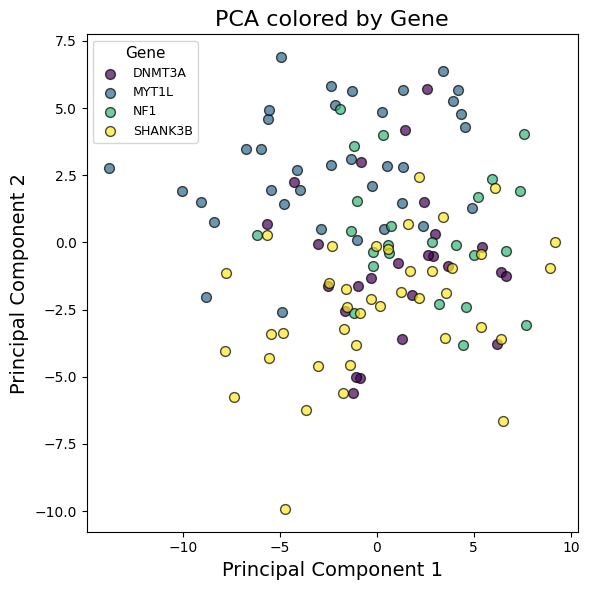

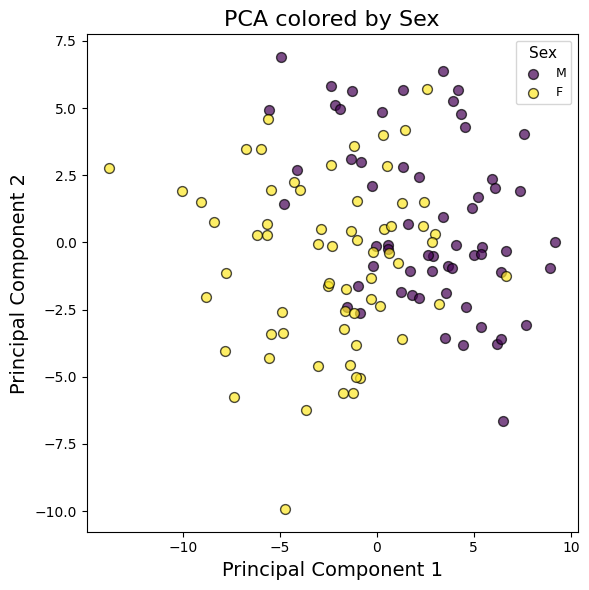

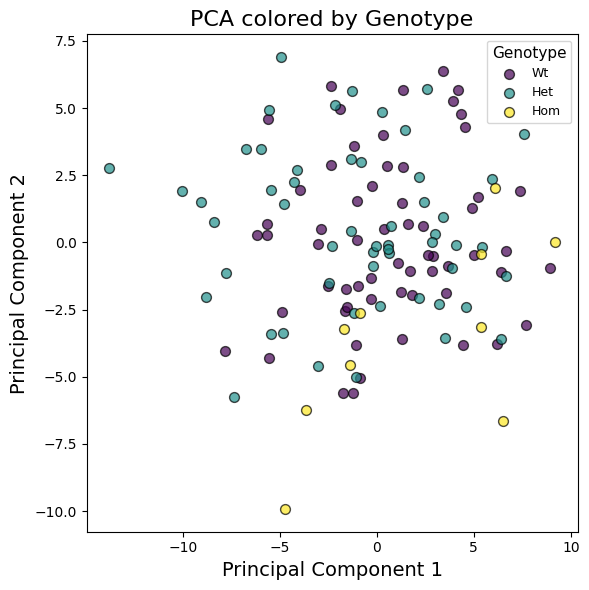

In [29]:
####### PCA Plotting #######
pca = PCA(n_components=2)
clustering_df_pca = pca.fit_transform(pca_df)

clustering_df_pca = pd.DataFrame(data = clustering_df_pca,
                                 columns = ['principal component 1', 'principal component 2'])

print('Explained variability per principal component: {}'.format(pca.explained_variance_ratio_))

#plt.figure()
#plt.figure(figsize=(5,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=14)
#plt.xlabel('Principal Component - 1',fontsize=20)
#plt.ylabel('Principal Component - 2',fontsize=20)
#plt.title("Principal Component Analysis Behavoirs", fontsize=20)
#targets = df_all['Gene'].unique()
#colors = ['r', 'g', 'b', 'y', 'p']
#for target, color in zip(targets,colors):
#    indicesToKeep = df_all['Gene'] == target
#    plt.scatter(clustering_df_pca.loc[indicesToKeep, 'principal component 1'],
#                clustering_df_pca.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
#
#plt.legend(targets,prop={'size': 8})


# Colummns for coloring
categorical_columns = ['Gene', 'Sex', 'Genotype']

for cat_col in categorical_columns:
    plt.figure(figsize=(6,6))
    plt.title(f"PCA colored by {cat_col}", fontsize=16)
    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)

    ### Get unique groups for column ###
    targets = df_all[cat_col].dropna().unique()

    # Generate colors
    cmap = plt.cm.get_cmap('viridis', len(targets))
    colors = [cmap(i) for i in range(len(targets))]

    ### Scatter for each group ###
    for i, target in enumerate(targets):
        indicesToKeep = df_all[cat_col] == target
        plt.scatter(
            clustering_df_pca.loc[indicesToKeep, 'principal component 1'],
            clustering_df_pca.loc[indicesToKeep, 'principal component 2'],
            color=colors[i],
            s=50,
            alpha=0.7,
            edgecolors='k',
            label=str(target)
        )

    plt.legend(title=cat_col, fontsize=9, title_fontsize=11)
    plt.tight_layout()
    plt.show()

# Create K-Cluster Elbow Plot to Prepare Discovery of Clusters

In [ ]:
####### Explore how many K clusters #######

# Initialize variables for Elbow Method
inertia = []
K_range = range(2, 11) # Testing 2 to 10 clusters

# Iterate over potential numer of clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=25).fit(pca_df)
    inertia.append(kmeans.inertia_) # Within-cluster sum of squares
# Plot the Elbow Method
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)', fontsize = 15)
plt.ylabel('Within-Cluster Sum of Squares)', fontsize=15)
plt.grid(True)

# Perform the clustering using K from Above

In [ ]:
# Perform k-means clustering and save
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(pca_df)

# PCA for visualization
pca = PCA(n_components=2)
clustering_df_pca = pca.fit_transform(pca_df)

# Plot our pca data colored by clusters
plt.figure(figsize=(4,4))
plt.scatter(clustering_df_pca[:, 0], clustering_df_pca[:, 1], c=labels,
            cmap='viridis', s=30)
plt.title('K-Means Clusters (PCA 2D Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')